# Business Problems
* sertifikasi wine --> untuk marketing ploy
* Sertifikasi wine dilakukan oleh Master Sommelier yang harganya seringkali mahal (595 usd - 1.195 usd), jumlahnya sedikit
* Penilaian dari Master Sommelier seringkali subjective

* how can we differentiate good and bad wine without sommeliers? --> prediction

# Data

In [44]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
df_wine=pd.read_csv('white_wine.csv')
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


In [46]:
df_wine=df_wine[['fixed acidity','chlorides','density','alcohol','quality']].copy()

# Preprocess

In [47]:
df_wine[['fixed acidity','chlorides']].describe()

,fixed acidity,chlorides
count,520.000000,520.000000
mean,6.812115,0.047781
std,0.730447,0.023006
min,5.000000,0.020000
25%,6.300000,0.038000
50%,6.800000,0.045000
75%,7.200000,0.052000
max,10.200000,0.346000


C:\Users\brigi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


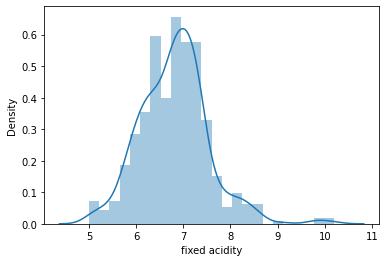

In [48]:
sns.distplot(df_wine['fixed acidity'])

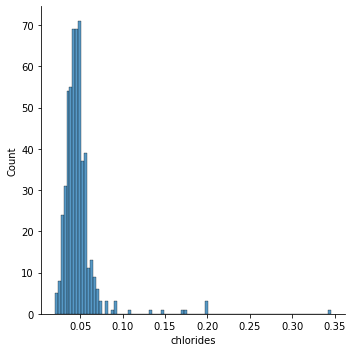

In [49]:
sns.displot(df_wine['chlorides'])

binning `fixed acidity` dan `chlorides`

In [50]:
def binning_fa(value):
    if value>8:
        return 'high'
    elif value>6.5:
        return 'medium'
    else:
        return 'low'
    
def binning_cl(value):
    if value>0.07:
        return 'high'
    elif value>0.05:
        return 'medium'
    else:
        return 'low'

In [51]:
df_wine['fixed acidity level']=df_wine['fixed acidity'].apply(binning_fa)
df_wine['chlorides level']=df_wine['chlorides'].apply(binning_cl)

In [52]:
df_wine.head()

,fixed acidity,chlorides,density,alcohol,quality,fixed acidity level,chlorides level
0,7.0,0.045,1.0010,8.8,6.0,medium,low
1,6.3,0.049,0.9940,9.5,6.0,low,low
2,8.1,0.050,0.9951,10.1,6.0,high,low
3,7.2,0.058,0.9956,9.9,6.0,medium,medium
4,7.2,0.058,0.9956,9.9,6.0,medium,medium


In [54]:
df_wine['label']=np.where(df_wine['quality']>6,1,0)

In [55]:
df_wine.isna().sum()

fixed acidity          0
chlorides              0
density                0
alcohol                1
quality                1
fixed acidity level    0
chlorides level        0
label                  0
dtype: int64

In [57]:
df_wine['alcohol']=df_wine['alcohol'].fillna(df_wine['alcohol'].mean())

In [58]:
# ilustrasi, train= data yang kalian pakai untuk mmebuat model
# test: data baru 

In [60]:
wine_train=df_wine[['alcohol','density','fixed acidity level','chlorides level','label']][:400]
wine_test=df_wine[['alcohol','density','fixed acidity level','chlorides level','label']][400:]

In [61]:
wine_train.to_csv('wine_train.csv',index=False)
wine_test.to_csv('wine_test.csv',index=False)

In [62]:
df_wine['label'].value_counts()

0    422
1     98
Name: label, dtype: int64

# Model Training
kita sudah tau model yang ingin dipakai  

* kelas 0: bad wine
* kelas 1: good wine

kesalahan:
FP: prediksi good wine, actual bad wine --> hasil sertifikasi tidak dipercaya
FN: prediksi bad wine, actual good wine --> produsen wine kecewa

FP lebih fatal--> fokus ke precision, tapi karena imbalance, pakai F1 dalam pemilihan model.

In [64]:
# model
from sklearn.linear_model import LogisticRegression

# feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

#evaluation
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, classification_report

#saving/loading models
import pickle
import joblib

In [65]:
# data
wine_train=pd.read_csv('wine_train.csv')

In [66]:
# preprocess
poly=PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

transformer= ColumnTransformer([
    ('poly',poly,['alcohol','density']),
    ('onehot',OneHotEncoder(drop='first'),['fixed acidity level','chlorides level'])
])

In [67]:
# splitting
x=wine_train.drop(columns='label')
y=wine_train['label']

x_train, x_test, y_train, y_test= train_test_split(x,y, stratify=y, random_state=2020)

In [68]:
# model tunning
model= LogisticRegression(solver='liblinear',random_state=2020)
estimator= Pipeline([
    ('preprocess', transformer),
    ('model',model)
])

In [69]:
hyperparam_space={
    'model__C':[100,10,1,0.1,0.01,0.001],
    'model__solver':['liblinear','newton-cg']
}

In [70]:
skfold=StratifiedKFold(n_splits=5)

grid_search= GridSearchCV(
    estimator=estimator,
    param_grid= hyperparam_space,
    cv=skfold,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(x_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('poly',
                                                                         PolynomialFeatures(degree=3,
                                                                                            include_bias=False),
                                                                         ['alcohol',
                                                                          'density']),
                                                                        ('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['fixed '
                                                                          'acidity '
                                              

In [71]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'model__C': 100, 'model__solver': 'liblinear'}
0.9482141047358439


In [72]:
#performa di data test
best_model=grid_search.best_estimator_

In [73]:
best_model.fit(x_train,y_train)
print(classification_report(y_test,best_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        81
           1       0.86      0.95      0.90        19

    accuracy                           0.96       100
   macro avg       0.92      0.96      0.94       100
weighted avg       0.96      0.96      0.96       100



# Saving and using models with Pickle 

In [74]:
best_model=grid_search.best_estimator_
best_model.fit(x,y) 
#fitting dengan seluruh data x dan y untuk model final --> semakin banyak data, seharusnya semakin baik model bekerja

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('poly',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['alcohol', 'density']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['fixed acidity level',
                                                   'chlorides level'])])),
                ('model',
                 LogisticRegression(C=100, random_state=2020,
                                    solver='liblinear'))])

In [75]:
# saving model with pickle
filename='model_pickle.sav'
pickle.dump(best_model,open(filename,'wb'))

In [76]:
# load datatest
wine_test=pd.read_csv('wine_test.csv')
#load model
filename='model_pickle.sav'
loaded_model=pickle.load(open(filename,'rb'))

## Predict

In [78]:
y_pred=loaded_model.predict(wine_test.drop(columns='label'))

In [79]:
f1_score(wine_test['label'],y_pred) #model mampu mengeneralisasi

0.9

In [80]:
print(classification_report(wine_test['label'],y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        99
           1       0.95      0.86      0.90        21

    accuracy                           0.97       120
   macro avg       0.96      0.92      0.94       120
weighted avg       0.97      0.97      0.97       120



In [82]:
wine_test[0:1]

,alcohol,density,fixed acidity level,chlorides level,label
0,11.4,0.9917,low,low,0


In [83]:
loaded_model.predict(wine_test[0:1])

array([0], dtype=int64)

## Making a simple predictor

In [87]:
df_predict=pd.DataFrame({
    'alcohol':[10],
    'density':[0.999],
    'fixed acidity level':['high'],
    'chlorides level':['low']
})
df_predict #data yang ingin diprediksi
#perhatikan kalau nama kolom dan isi kategori harus sesuai dengan data yg difit ke model

,alcohol,density,fixed acidity level,chlorides level
0,10,0.999,high,low


In [90]:
print('predict class:', loaded_model.predict(df_predict))
print('predict proba:', loaded_model.predict_proba(df_predict)[0,1])

predict class: [0]
predict proba: 0.31332093602428923


In [92]:
x.describe()

,alcohol,density
count,400.000000,400.000000
mean,10.095250,0.995458
std,1.069749,0.002584
min,8.500000,0.990000
25%,9.200000,0.993600
50%,9.900000,0.995500
75%,10.800000,0.997400
max,12.800000,1.003300


In [95]:
def predict():
    alc=float(input('masukkan nilai alkohol (dari 8.5-12.8) '))
    dens=float(input('masukkan nilai density (dari 0.9900-1.0033) '))
    fal=input('masukkan nilai fixed acidity level (low, medium, high) ')
    cl=input('masukkan nilai chlorides level (low, medium, high) ')
    
    df_predict=pd.DataFrame({
    'alcohol':[alc],
    'density':[dens],
    'fixed acidity level':[fal],
    'chlorides level':[cl]})
    
    filename='model_pickle.sav'
    loaded_model=pickle.load(open(filename,'rb'))
    
    print('predict class', loaded_model.predict(df_predict)[0])
    print('predict proba:', loaded_model.predict_proba(df_predict)[0,1])

In [96]:
predict()

masukkan nilai alkohol (dari 8.5-12.8) 9
masukkan nilai density (dari 0.9900-1.0033) 0.99
masukkan nilai fixed acidity level (low, medium, high) high
masukkan nilai chlorides level (low, medium, high) high
predict class 0
predict proba: 8.167718810496194e-08


# Saving and using models with Joblib

In [97]:
# saving model
joblib.dump(best_model,'model joblib')

['model joblib']

In [98]:
# load model
model_joblib=joblib.load('model joblib')

In [99]:
# predict
model_joblib.predict(wine_test[0:1])

array([0], dtype=int64)